In [1]:
from langgraph.graph import StateGraph,START,END
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from langchain.output_parsers import PydanticOutputParser
from dotenv import load_dotenv
from typing import TypedDict,Annotated
from pydantic import BaseModel ,Field

import operator

c:\Users\shrey\Desktop\langGraph\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [8]:
load_dotenv()

True

In [3]:
llm = HuggingFaceEndpoint(
    model='Qwen/Qwen3-Next-80B-A3B-Instruct',
    task= 'text-generation'
)
model = ChatHuggingFace(llm=llm)

In [4]:
class EvaluationSchema(BaseModel):
    feedback: str = Field(description = 'detailed feedback of the essay')
    score: int = Field(description='score out of 10',ge=0,le=10)

In [5]:
parser = PydanticOutputParser(pydantic_object=EvaluationSchema)

In [6]:
essay = """
Agentic AI: An Emerging Field
Artificial Intelligence has progressed rapidly from narrow task-specific systems to increasingly autonomous and adaptive models. One of the most promising developments in this trajectory is the rise of Agentic AI. Unlike traditional AI, which primarily acts as a tool to process inputs and generate outputs, Agentic AI is designed to operate as an autonomous agent—capable of reasoning, planning, and interacting with its environment in a more human-like way.
Agentic AI systems are not limited to performing isolated tasks. They can set goals, decompose problems, take actions, and learn from feedback in dynamic environments. This shift makes them more powerful and versatile, particularly in domains where human-level adaptability is required, such as scientific discovery, robotics, business process automation, and personalized digital assistance. For example, an agentic AI could independently research a topic, compare sources, generate solutions, and refine its strategies based on results—all without constant human direction.
The emergence of Agentic AI is supported by advancements in large language models, reinforcement learning, and multi-agent simulations. Researchers are exploring frameworks where these systems collaborate, negotiate, or even compete, creating new possibilities for collective intelligence. However, with these opportunities come challenges. Concerns around safety, alignment, accountability, and ethical decision-making are at the forefront of discussions. An AI that can act autonomously must also be carefully constrained to ensure that its actions remain beneficial and aligned with human values.
In conclusion, Agentic AI represents a new stage in the evolution of artificial intelligence—moving from static tools to adaptive, goal-driven entities. While the technology is still in its early stages, its potential to transform industries and reshape human-computer interaction is immense. As research continues, balancing innovation with safety and ethical responsibility will be crucial in unlocking the benefits of this emerging field."""

In [7]:
prompt = f"""
Evaluate the following essay and provide detailed feedback and score.

Essay:
{essay}

Return output strictly in JSON format following this schema:
{parser.get_format_instructions()}

Ensure 'score' is always numeric (integer 0-10), not words.
"""

raw_output = model.invoke(prompt)


In [149]:
print(raw_output)

content='{\n  "feedback": "The essay provides a clear, well-structured, and thoughtful overview of Agentic AI. It effectively defines the concept by contrasting it with traditional AI, highlighting key characteristics such as autonomy, goal-setting, planning, and environmental interaction. The inclusion of concrete examples—like autonomous research and dynamic strategy refinement—strengthens the argument and enhances readability. The essay also appropriately addresses the technological enablers (LLMs, reinforcement learning, multi-agent systems) and thoughtfully acknowledges the ethical and safety challenges, demonstrating balanced critical thinking. The conclusion succinctly summarizes the significance of the field and underscores the need for responsible innovation. Minor improvements could include deeper elaboration on specific frameworks (e.g., AutoGPT, BabyAGI) or real-world pilot applications to ground the discussion further. Additionally, while the essay is logically coherent, a

In [151]:
result = parser.parse(raw_output.content)

In [152]:
print(result)

feedback='The essay provides a clear, well-structured, and thoughtful overview of Agentic AI. It effectively defines the concept by contrasting it with traditional AI, highlighting key characteristics such as autonomy, goal-setting, planning, and environmental interaction. The inclusion of concrete examples—like autonomous research and dynamic strategy refinement—strengthens the argument and enhances readability. The essay also appropriately addresses the technological enablers (LLMs, reinforcement learning, multi-agent systems) and thoughtfully acknowledges the ethical and safety challenges, demonstrating balanced critical thinking. The conclusion succinctly summarizes the significance of the field and underscores the need for responsible innovation. Minor improvements could include deeper elaboration on specific frameworks (e.g., AutoGPT, BabyAGI) or real-world pilot applications to ground the discussion further. Additionally, while the essay is logically coherent, a brief mention of

In [176]:
class UPSCState(TypedDict):

    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float

In [177]:
def evaluate_language(state: UPSCState):
    prompt = f"""
Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}


Return output strictly in JSON format following this schema:
{parser.get_format_instructions()}

Ensure 'score' is always numeric (integer 0-10), not words.
"""

    output = model.invoke(prompt)
    result = parser.parse(output.content)
    
    

    return {'language_feedback': result.feedback, 'individual_scores': [result.score]}

In [178]:
def evaluate_analysis(state: UPSCState):
    prompt = f"""
Evaluate the depth of analysis of the following essay and provide feedback and assign a score out of 10
Essay: {state['essay']}

Return output strictly in JSON format following this schema:
{parser.get_format_instructions()}

Ensure 'score' is always numeric (integer 0-10), not words.
"""

    output = model.invoke(prompt)
    result = parser.parse(output.content)

    return {
        "analysis_feedback": result.feedback,
        "individual_scores": [result.score]
    }

In [179]:
def evaluate_thought(state):
    prompt = f"""
Evaluate the clarity of thought of the following essay and provide feedback and assign a score out of 10
Essay: {state['essay']}

Return output strictly in JSON format following this schema:
{parser.get_format_instructions()}

Ensure 'score' is always numeric (integer 0-10), not words.
"""

    # Invoke model
    output = model.invoke(prompt)

    # Parse structured output
    result = parser.parse(output.content)

    return {
        "clarity_feedback": result.feedback,
        "individual_scores": [result.score]
    }


In [180]:
class FinalEvaluationSchema(BaseModel):
    overall_feedback: str = Field(description="Summarized feedback combining all individual feedbacks")
    avg_score: float = Field(description="Average score of all individual scores (0-10)", ge=0, le=10)

#Parser
final_parser = PydanticOutputParser(pydantic_object=FinalEvaluationSchema)

def final_evaluation(state):
    prompt = f"""
Based on the following feedbacks, create a summarized overall feedback for the essay and provide an overall average score out of 10.

Language feedback: {state['language_feedback']}
Depth of analysis feedback: {state['analysis_feedback']}
Clarity of thought feedback: {state['clarity_feedback']}

Return output strictly in JSON format following this schema:
{final_parser.get_format_instructions()}

Ensure 'avg_score' is always numeric (float 0-10).
"""

    # Invoke model
    output = model.invoke(prompt)

    # Parse structured output
    result = final_parser.parse(output.content)

    return {
        "overall_feedback": result.overall_feedback,
        "avg_score": result.avg_score
    }

In [181]:
graph = StateGraph(UPSCState)

graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_thought', evaluate_thought)
graph.add_node('final_evaluation', final_evaluation)

# edges
graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_thought')

graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('evaluate_thought', 'final_evaluation')

graph.add_edge('final_evaluation', END)

workflow = graph.compile()

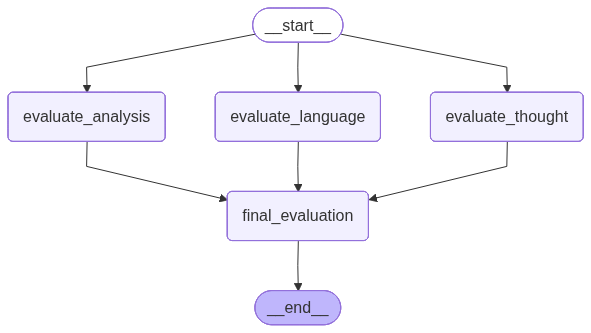

In [182]:
workflow

In [183]:
essay2 = """India and AI Time

Now world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.

India have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.

In farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.

But problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.

One more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.

India must all people together – govern, school, company and normal people. We teach AI and make sure AI not bad. Also talk to other country and learn from them.

If India use AI good way, we become strong, help poor and make better life. But if only rich use AI, and poor no get, then big bad thing happen.

So, in short, AI time in India have many hope and many danger. We must go right road. AI must help all people, not only some. Then India grow big and world say "good job India"."""

In [187]:
intial_state = {
    'essay': essay2
}

final = workflow.invoke(intial_state)


In [188]:
print(" Overall Feedback:\n", final["overall_feedback"])
print("\nAverage Score:", round(final["avg_score"], 2), "/ 10")

 Overall Feedback:
 The essay demonstrates a commendable awareness of AI's potential and challenges in India, with relevant examples across agriculture, healthcare, education, and governance. The core ideas—such as the digital divide, job displacement, data privacy, and the need for inclusive AI—are logically arranged and socially conscious. However, the expression is severely hindered by pervasive grammatical errors, informal and broken phrasing (e.g., 'big big data', 'engine-ear', 'no have phone'), inconsistent verb tenses, missing articles, and poor sentence structure. The language lacks academic tone and professionalism, reducing clarity and credibility. Analysis remains superficial, with no supporting data, scholarly references, or exploration of counterarguments, policy frameworks, or algorithmic bias. Transitions are weak, structure is underdeveloped, and the conclusion is repetitive rather than synthesizing insights. While the conceptual understanding is solid and the intent is